In [1]:
%load_ext autoreload
%autoreload 2

## Download the small test dataset first

If working on Colab or you have gsutil installed on your local machine, try the code block below; otherwise, use the [link](https://storage.googleapis.com/kidney_dataset/test_data.zip) to download the dataset and move it to `/tmp/test_data/` folder.

In [2]:
!mkdir -p /tmp/test_data/
!gsutil cp "gs://kidney_dataset/test_data.zip" "/tmp/test_data/"

Copying gs://kidney_dataset/test_data.zip...
| [1 files][ 69.9 MiB/ 69.9 MiB]                                                
Operation completed over 1 objects/69.9 MiB.                                     


In [3]:
!unzip -o /tmp/test_data/test_data.zip -d /tmp/test_data/

Archive:  /tmp/test_data/test_data.zip
   creating: /tmp/test_data/hdf5_source/
  inflating: /tmp/test_data/hdf5_source/PAS_005_tuft_mask.png  
  inflating: /tmp/test_data/hdf5_source/PAS_005.png  
  inflating: /tmp/test_data/hdf5_source/PAS_004_tuft_mask.png  
  inflating: /tmp/test_data/hdf5_source/PAS_004.png  
  inflating: /tmp/test_data/hdf5_source/PAS_003_tuft_mask.png  
  inflating: /tmp/test_data/hdf5_source/PAS_003_capsule_mask.png  
  inflating: /tmp/test_data/hdf5_source/PAS_003.png  
  inflating: /tmp/test_data/hdf5_source/PAS_002_tuft_mask.png  
  inflating: /tmp/test_data/hdf5_source/PAS_002.png  
  inflating: /tmp/test_data/hdf5_source/PAS_001_tuft_mask.png  
  inflating: /tmp/test_data/hdf5_source/PAS_001_capsule_mask.png  
  inflating: /tmp/test_data/hdf5_source/PAS_001.png  


## Create hdf5 dataset

In [4]:
from pathlib import Path

In [5]:
input_data_root = Path("/tmp/test_data/hdf5_source/")
output_data_root = Path("/tmp/test_data/hdf5_output")
output_data_root.mkdir(exist_ok=True)

In [6]:
from patches_extraction import extract_img_patches, extract_mask_patches, Extractor, crop_and_save_patches_to_hdf5

In [7]:
extractor = Extractor(resize=0.25, mirror_pad_size=128, patch_size=256, stride_size=64)

In [8]:
images = [p for p in input_data_root.glob("*.png") if "mask" not in str(p)]
images.sort()
images

[PosixPath('/tmp/test_data/hdf5_source/PAS_001.png'),
 PosixPath('/tmp/test_data/hdf5_source/PAS_002.png'),
 PosixPath('/tmp/test_data/hdf5_source/PAS_003.png'),
 PosixPath('/tmp/test_data/hdf5_source/PAS_004.png'),
 PosixPath('/tmp/test_data/hdf5_source/PAS_005.png')]

In [9]:
masks = [p for p in input_data_root.glob("*tuft_mask.png")]
masks.sort()
masks

[PosixPath('/tmp/test_data/hdf5_source/PAS_001_tuft_mask.png'),
 PosixPath('/tmp/test_data/hdf5_source/PAS_002_tuft_mask.png'),
 PosixPath('/tmp/test_data/hdf5_source/PAS_003_tuft_mask.png'),
 PosixPath('/tmp/test_data/hdf5_source/PAS_004_tuft_mask.png'),
 PosixPath('/tmp/test_data/hdf5_source/PAS_005_tuft_mask.png')]

In [10]:
hdf5_dataset_fname = output_data_root / "PAS_glom_train.h5"
hdf5_dataset_fname

PosixPath('/tmp/test_data/hdf5_output/PAS_glom_train.h5')

In [11]:
# test the function of image extraction helper function
patches, image_indices = extract_img_patches(images[0], extractor)
patches.shape, len(image_indices)

/home/henryhuang/.conda/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function extract_patches is deprecated; The function feature_extraction.image.extract_patches has been deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(msg, category=FutureWarning)


((144, 256, 256, 3), 144)

In [12]:
# test the function of mask extraction helper function
mask_patches, mask_indices = extract_mask_patches(masks[0],extractor)
mask_patches.shape, len(mask_indices)

((144, 256, 256, 3), 124)

In [13]:
# test the main function used for generating hdf5 file
crop_and_save_patches_to_hdf5(hdf5_dataset_fname, images, masks, extractor)

In [14]:
!ls $output_data_root

PAS_glom_train.h5


## Load data as torch Dataset and Dataloader

In [15]:
from dataset import Dataset
import torch
from torch.utils.data import DataLoader
import albumentations as A

In [16]:
# parameters for augmentations and training
patch_size = 256
device = torch.device("cuda:0")
edge_weight = 1.2

In [17]:
# do not apply any transformation related to data type casting, 
# e.g. toTenser() here. Also use albumentations Compose API instead of torchvision.
aug_transform = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.HueSaturationValue(),
        A.ToGray()
    ])
])

In [27]:
hdf5_dataset_fname = Path("/tmp/test_data/hdf5_output/PAS_glom_train.h5")

In [28]:
dataset = Dataset(hdf5_dataset_fname, 
                  aug_transform=aug_transform,
                  use_edge_mask=True)

In [39]:
from dataset import visualize_one_sample

Sample 50 has the 50-th positive mask.


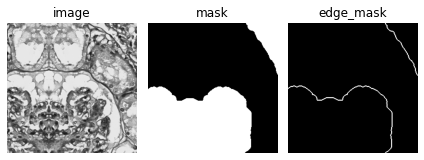

In [42]:
visualize_one_sample(dataset, 50, positive_only=True)

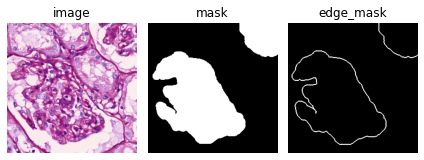

In [43]:
visualize_one_sample(dataset, 60, positive_only=False)

In [44]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

## Simulate the training procedure to test the functionality of dataloader

In [6]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

In [13]:
from training.unet import UNet
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [14]:
unet = UNet(in_channels=3,
            n_classes=5,
            depth = 8,# this depth may need to be modified
            wf = 3,
            padding = True,
            batch_norm = True,
            up_mode = "upconv"
            ).to(device)

optimizer = torch.optim.Adam(params = unet.parameters(),lr = 1e-3)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience = 25, verbose = True)
criterion = nn.CrossEntropyLoss(reduction="none")
EPOCH = 10

In [16]:
import os
#tensorboard if necessary
%load_ext tensorboard
logs_base_dir = "runs"
os.makedirs(logs_base_dir, exist_ok=True)
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/Users/alexli/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/alexli/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/alexli/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/alexli/anaconda3/lib/python3.7/site-packages/tensor

In [46]:
for epochs in tqdm(range(EPOCHS), desc = "Epochs", leave = True):
    for i, data in enumerate(dataloader):
        img, mask, edge_mask = list(map(lambda x: x.to(device), data))
        if i == 0:
            list(map(lambda x: print(f"Shape: {x.shape}, Dtype: {x.dtype}"), data))

        unet.zero_grad()
        # generate a naive prediction using binary random samples
        output = unet(img)

        loss_matrix = criterion(output, mask)
        loss = (loss_matrix * (edge_weight**edge_mask)).mean()

        loss.backward()
        optimizer.step()
        l = loss.item()
        tb.add_scalar("loss", epoches*, i)
        print(f"Batch {i} has loss: {loss_val}")
    scheduler.step(l)
    

Shape: torch.Size([8, 256, 256, 3]), Dtype: torch.float32
Shape: torch.Size([8, 256, 256]), Dtype: torch.int64
Shape: torch.Size([8, 256, 256]), Dtype: torch.float32
Batch 0 has loss: 0.7148913145065308
Batch 1 has loss: 0.7148382663726807
Batch 2 has loss: 0.7146433591842651
Batch 3 has loss: 0.7146958112716675
Batch 4 has loss: 0.7135518193244934
Batch 5 has loss: 0.7146928310394287
Batch 6 has loss: 0.7148191332817078
Batch 7 has loss: 0.7147542238235474
Batch 8 has loss: 0.7153436541557312
Batch 9 has loss: 0.7138068675994873
Batch 10 has loss: 0.7146798968315125
Batch 11 has loss: 0.7154009342193604
Batch 12 has loss: 0.7149342894554138
Batch 13 has loss: 0.7148914337158203
Batch 14 has loss: 0.7147197723388672
Batch 15 has loss: 0.7153342962265015
Batch 16 has loss: 0.7148448824882507
Batch 17 has loss: 0.7142089009284973
Batch 18 has loss: 0.7144242525100708
Batch 19 has loss: 0.7139675617218018
Batch 20 has loss: 0.7150285243988037
Batch 21 has loss: 0.7145296335220337
Batch 22